In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q transformers evaluate decord accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 71.8 MB/s eta 0:00:00


In [3]:
!unzip -q "/content/drive/MyDrive/action-video.zip" -d "/content/"

In [10]:
import torch
import cv2
import numpy as np
import copy
import os
import pandas as pd
import pathlib
from pathlib import Path
from tqdm.auto import tqdm
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import GroupShuffleSplit
from torch.utils.data import Subset
from transformers import (
    VideoMAEImageProcessor,
    VideoMAEForVideoClassification,
    TrainingArguments,
    Trainer
)
import evaluate

MODEL_CKPT = "MCG-NJU/videomae-base-finetuned-kinetics"
BATCH_SIZE = 4
EPOCHS = 8
NUM_FRAMES = 16
LEARNING_RATE = 5e-5
SEED = 42

TRAIN_DIR = Path('/content/action-video/data/data_train')
TEST_DIR = Path('/content/action-video/data/test')

In [5]:
class MotionAwareDataset(Dataset):
    def __init__(self, root_dir, image_processor, num_frames=16, is_train=True):
        self.root = pathlib.Path(root_dir)
        self.image_processor = image_processor
        self.num_frames = num_frames
        self.is_train = is_train

        self.classes = sorted([d.name for d in self.root.iterdir() if d.is_dir()])
        self.class2id = {c: i for i, c in enumerate(self.classes)}
        self.id2class = {i: c for c, i in self.class2id.items()}

        self.samples = []
        print(f"🔍 Đang quét dữ liệu ({'TRAIN' if is_train else 'VAL/TEST'})...")
        for cls in self.classes:
            cls_path = self.root / cls
            for vid_folder in sorted([d for d in cls_path.iterdir() if d.is_dir()]):
                frames = sorted([str(p) for p in vid_folder.glob('*.jpg')])
                if len(frames) > 0:
                    self.samples.append((frames, self.class2id[cls]))
        print(f"   -> Tìm thấy {len(self.samples)} video.")

    def __len__(self):
        return len(self.samples)

    def _get_motion_score(self, img_path1, img_path2):
        """
        Tính điểm chuyển động bằng Frame Difference (AbsDiff).
        Nhanh hơn Optical Flow, phù hợp để quét toàn bộ video.
        """
        try:
            # 1. Đọc ảnh xám
            im1 = cv2.imread(img_path1, cv2.IMREAD_GRAYSCALE)
            im2 = cv2.imread(img_path2, cv2.IMREAD_GRAYSCALE)
            if im1 is None or im2 is None: return 0.0

            # 2. Resize nhỏ (64x64) để tính toán siêu tốc
            # Dù absdiff nhanh, nhưng resize giúp giảm I/O và tính toán thêm nữa
            im1 = cv2.resize(im1, (64, 64))
            im2 = cv2.resize(im2, (64, 64))

            # 3. Tính tổng chênh lệch tuyệt đối (L1 Norm)
            diff = cv2.absdiff(im1, im2)
            return np.sum(diff)
        except Exception:
            return 0.0

    def __getitem__(self, idx):
        frame_paths, label = self.samples[idx]
        total_frames = len(frame_paths)
        final_indices = []

        # TRƯỜNG HỢP 1: Video quá ngắn (< 16 frame) -> Lặp vòng (Loop)
        if total_frames < self.num_frames:
            indices = np.arange(total_frames)
            needed = self.num_frames - total_frames

            # Kỹ thuật Loop Padding: [0, 1, 2, 0, 1...]
            if needed > 0:
                repeats = (needed // total_frames) + 1
                padding = np.tile(indices, repeats)[:needed]
                final_indices = np.concatenate([indices, padding])
            else:
                final_indices = indices

        # TRƯỜNG HỢP 2: Video đủ dài -> Quét TẤT CẢ frame
        else:
            scores = []

            # Duyệt qua TOÀN BỘ video (Không dùng candidates nữa)
            # Tính điểm sự khác biệt giữa frame i và frame i+1
            for i in range(total_frames - 1):
                score = self._get_motion_score(frame_paths[i], frame_paths[i+1])
                scores.append(score)

            # Xử lý frame cuối (gán điểm 0 vì không có frame sau để so sánh)
            scores.append(0.0)
            scores = np.array(scores)

            # Chọn Top 16 frame có sự thay đổi pixel lớn nhất
            top_indices = np.argsort(scores)[-self.num_frames:]

            # Sắp xếp lại theo thời gian để video đúng thứ tự hành động
            final_indices = np.sort(top_indices)

        # LOAD ẢNH VÀ TRẢ VỀ
        video = []
        for i in final_indices:
            try:
                img_path = frame_paths[int(i)]
                img = Image.open(img_path).convert("RGB")
                video.append(np.array(img))
            except:
                video.append(np.zeros((224, 224, 3), dtype=np.uint8))

        # Processor
        inputs = self.image_processor(list(video), return_tensors="pt")

        return {
            "pixel_values": inputs["pixel_values"].squeeze(),
            "labels": torch.tensor(label)
        }

In [8]:
# 1. Image Processor
image_processor = VideoMAEImageProcessor.from_pretrained(MODEL_CKPT)

# 2. Dataset
full_dataset = MotionAwareDataset(TRAIN_DIR, image_processor, num_frames=NUM_FRAMES, is_train=True)

# 3. SPLIT TRAIN/VAL

# B1: Trích xuất "Group ID" từ tên thư mục video
# Ví dụ: "April_09_brush_hair_..._goo_1" -> Group ID: "April_09_brush_hair_..._goo"
group_ids = []
print("Đang tạo Group ID để chia dữ liệu...")

for frame_paths, label in full_dataset.samples:
    # Lấy đường dẫn folder chứa video hiện tại
    # frame_paths[0] là đường dẫn ảnh -> .parent là folder video
    video_folder_name = Path(frame_paths[0]).parent.name

    # Cắt bỏ phần số đuôi (ví dụ _1, _2) để lấy tên gốc
    try:
        root_name = video_folder_name.rsplit('_', 1)[0]
    except:
        root_name = video_folder_name # Fallback nếu tên không có dấu _

    group_ids.append(root_name)

# B2: Sử dụng GroupShuffleSplit
# Nó đảm bảo các video cùng root_name sẽ nằm hết bên Train hoặc hết bên Val
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, val_idx = next(splitter.split(full_dataset.samples, groups=group_ids))

# B3: Tạo Subset từ index đã chia
train_ds = Subset(full_dataset, train_idx)
val_ds = Subset(full_dataset, val_idx)

# B4: Tắt Jitter cho tập Val
# Vì Subset trỏ về dataset gốc, ta cần deepcopy để sửa thuộc tính is_train
val_dataset_copy = copy.deepcopy(full_dataset)
val_dataset_copy.is_train = False
val_ds.dataset = val_dataset_copy

print(f"\nThống kê: Train={len(train_ds)} | Val={len(val_ds)} | Classes={len(full_dataset.classes)}")

# 4. Load Model
model = VideoMAEForVideoClassification.from_pretrained(
    MODEL_CKPT,
    label2id=full_dataset.class2id,
    id2label=full_dataset.id2class,
    ignore_mismatched_sizes=True,
    num_frames=NUM_FRAMES
)

🔍 Đang quét dữ liệu (TRAIN)...
   -> Tìm thấy 6254 video.
Đang tạo Group ID để chia dữ liệu...

Thống kê: Train=5046 | Val=1208 | Classes=51


Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base-finetuned-kinetics and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([51]) in the model instantiated
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([51, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Metric tính độ chính xác
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

# Cấu hình Trainer
args = TrainingArguments(
    output_dir="videomae-hmdb51-motion-aware",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    warmup_ratio=0.1,
    logging_steps=20,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
    fp16=True,
    gradient_accumulation_steps=4,
    dataloader_num_workers=2,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    processing_class=image_processor,
    compute_metrics=compute_metrics,
)

print("Bắt đầu Fine-tuning với chiến thuật Motion-Aware...")
trainer.train()

# Lưu model xịn nhất
best_model_path = "/content/drive/MyDrive/videomae_best_model_motion_aware"
trainer.save_model(best_model_path)
print(f"Đã lưu model tốt nhất tại: {best_model_path}")

Bắt đầu Fine-tuning với chiến thuật Motion-Aware...


Epoch,Training Loss,Validation Loss,Accuracy
1,1.193600,1.233249,0.747517
2,0.430100,0.761526,0.793874
3,0.182200,0.692157,0.814570
4,0.048600,0.679045,0.831954
5,0.006200,0.686944,0.828642
6,0.002900,0.667952,0.836921
7,0.002700,0.666233,0.838576
8,0.002100,0.666594,0.840232


Đã lưu model tốt nhất tại: /content/drive/MyDrive/videomae_best_model_motion_aware


In [11]:
best_model_path = "/content/drive/MyDrive/videomae_best_model_motion_aware"
trained_model = VideoMAEForVideoClassification.from_pretrained(best_model_path).to("cuda")
trained_model.eval()

# Lấy danh sách folder test
test_folders = sorted([d for d in TEST_DIR.iterdir() if d.is_dir()], key=lambda x: int(x.name))
predictions = []

with torch.no_grad():
    for vid_dir in tqdm(test_folders):
        vid_id = int(vid_dir.name)
        frames = sorted([str(p) for p in vid_dir.glob('*.jpg')])
        total_frames = len(frames)

        if total_frames == 0: continue

        final_indices = []

        # TRƯỜNG HỢP 1: Video quá ngắn (< 16 frame) -> Loop Padding
        if total_frames < NUM_FRAMES:
            indices = np.arange(total_frames)
            needed = NUM_FRAMES - total_frames

            # Kỹ thuật Loop Padding: [0, 1, 2, 0, 1...]
            if needed > 0:
                repeats = (needed // total_frames) + 1
                padding = np.tile(indices, repeats)[:needed]
                final_indices = np.concatenate([indices, padding])
            else:
                final_indices = indices

        # TRƯỜNG HỢP 2: Video đủ dài -> Quét AbsDiff toàn bộ
        else:
            scores = []

            # Quét từng cặp frame (i, i+1)
            for i in range(total_frames - 1):
                try:
                    # Đọc ảnh xám
                    im1 = cv2.imread(frames[i], cv2.IMREAD_GRAYSCALE)
                    im2 = cv2.imread(frames[i+1], cv2.IMREAD_GRAYSCALE)

                    if im1 is None or im2 is None:
                        scores.append(0)
                        continue

                    # Resize 64x64 để tính nhanh và khử nhiễu
                    im1 = cv2.resize(im1, (64, 64))
                    im2 = cv2.resize(im2, (64, 64))

                    # Tính tổng chênh lệch (Motion Score)
                    diff = np.sum(cv2.absdiff(im1, im2))
                    scores.append(diff)

                except:
                    scores.append(0)

            # Frame cuối cùng không có cặp -> Gán điểm 0
            scores.append(0)
            scores = np.array(scores)

            # Lấy Top 16 frame có điểm cao nhất
            top_indices = np.argsort(scores)[-NUM_FRAMES:]

            # Sắp xếp lại theo thời gian
            final_indices = np.sort(top_indices)

        # Load ảnh RGB & Predict
        video = []
        for i in final_indices:
            try:
                img = Image.open(frames[int(i)]).convert("RGB")
                video.append(np.array(img))
            except:
                # Fallback ảnh đen (An toàn)
                video.append(np.zeros((224, 224, 3), dtype=np.uint8))

        # Đưa vào Processor
        inputs = image_processor(list(video), return_tensors="pt")
        inputs = {k: v.to("cuda") for k, v in inputs.items()}

        # Predict
        logits = trained_model(**inputs).logits
        pred_label_idx = logits.argmax(-1).item()

        # Mapping từ ID sang Tên Class
        pred_class = full_dataset.id2class[pred_label_idx]

        predictions.append((vid_id, pred_class))

# Lưu file submission
df = pd.DataFrame(predictions, columns=['id', 'class'])
df = df.sort_values(by='id')
df.to_csv('submission.csv', index=False)

print(f"Đã xong")

  0%|          | 0/510 [00:00<?, ?it/s]

Đã xong


Đang chạy dự đoán để vẽ ảnh...


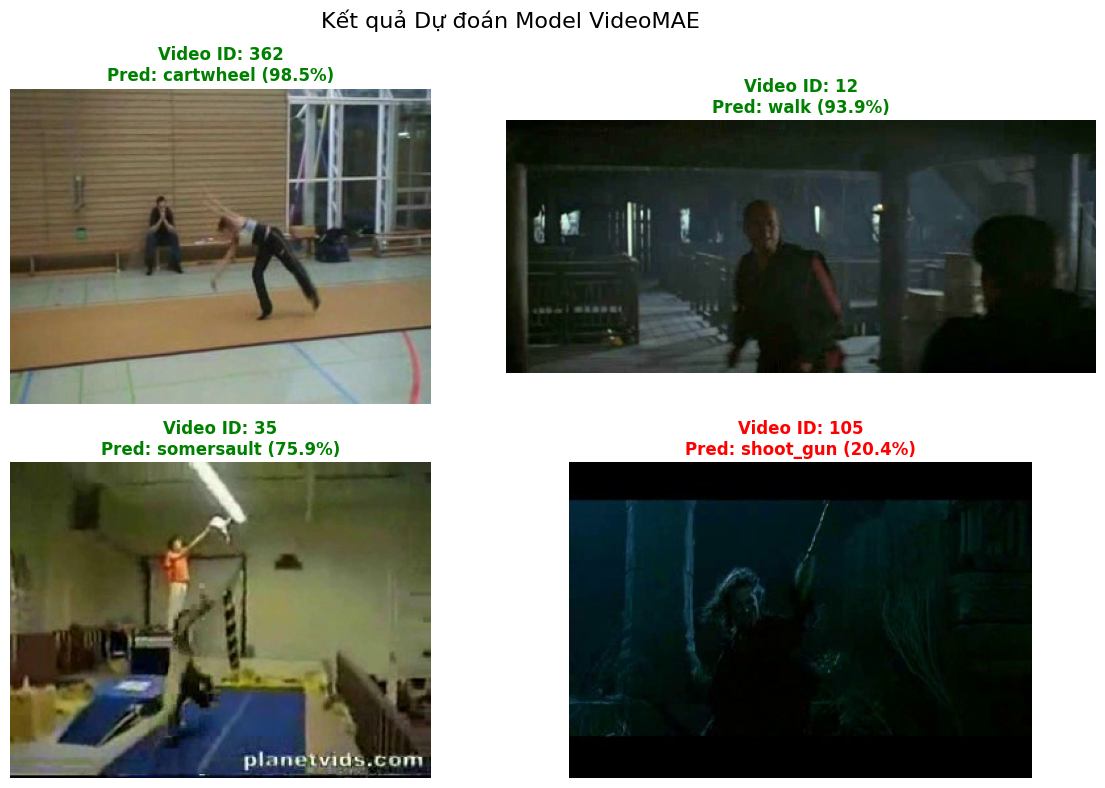

In [12]:
import matplotlib.pyplot as plt
import random
from PIL import Image

# Cấu hình
NUM_SAMPLES = 4
COLS = 2
ROWS = 2

trained_model.eval()

# Lấy ngẫu nhiên các mẫu từ tập Test
test_folders = sorted([d for d in TEST_DIR.iterdir() if d.is_dir()])
random_samples = random.sample(test_folders, NUM_SAMPLES)

fig, axes = plt.subplots(ROWS, COLS, figsize=(12, 8))
fig.suptitle(f'Kết quả Dự đoán Model VideoMAE', fontsize=16)

print("Đang chạy dự đoán để vẽ ảnh...")

for idx, vid_dir in enumerate(random_samples):
    ax = axes[idx // COLS, idx % COLS]

    frames = sorted([str(p) for p in vid_dir.glob('*.jpg')])
    if len(frames) == 0: continue

    # Lấy frame giữa để hiển thị tránh một số frame rác ở đầu một số video
    mid_frame_path = frames[len(frames)//2]
    display_img = Image.open(mid_frame_path)

    # 2. Xử lý Input cho Model
    indices = np.linspace(0, len(frames)-1, NUM_FRAMES).astype(int)
    video = []
    for i in indices:
        video.append(np.array(Image.open(frames[i]).convert("RGB")))

    inputs = image_processor(list(video), return_tensors="pt")
    inputs = {k: v.to("cuda") for k, v in inputs.items()}

    # 3. Predict
    with torch.no_grad():
        logits = trained_model(**inputs).logits
        pred_idx = logits.argmax(-1).item()
        confidence = torch.nn.functional.softmax(logits, dim=-1)[0][pred_idx].item()

    pred_label = full_dataset.id2class[pred_idx]

    # Lấy True Label

    # Vẽ ảnh
    ax.imshow(display_img)
    ax.axis('off')

    # Đổi màu tiêu đề: Xanh nếu tự tin cao, Đỏ nếu thấp
    color = 'green' if confidence > 0.7 else 'red'
    ax.set_title(f"Video ID: {vid_dir.name}\nPred: {pred_label} ({confidence:.1%})",
                 color=color, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

Đang phân tích chuyển động của video: 173


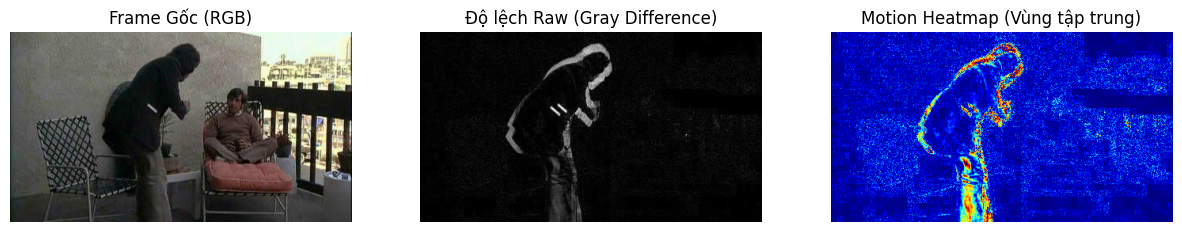

In [15]:
import cv2
import random
import matplotlib.pyplot as plt

def visualize_motion_mechanism(video_folder_path):
    """
    Vẽ minh họa cách thuật toán Motion-Aware nhìn thấy chuyển động
    """
    frames = sorted([str(p) for p in video_folder_path.glob('*.jpg')])
    if len(frames) < 2: return

    # Chọn 2 frame liên tiếp ở giữa video (thường có hành động mạnh nhất)
    mid = len(frames) // 2
    path1 = frames[mid]
    path2 = frames[mid + 1] # Frame kế tiếp

    # 1. Đọc ảnh gốc
    img1 = cv2.imread(path1)
    img2 = cv2.imread(path2)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) # Để hiển thị plt

    # 2. Tính Frame Difference
    gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Tính sai biệt tuyệt đối
    diff = cv2.absdiff(gray1, gray2)

    # 3. Tạo Heatmap cho đẹp (để đưa vào báo cáo)
    # Tăng độ tương phản để nhìn rõ đốm chuyển động
    _, thresh = cv2.threshold(diff, 20, 255, cv2.THRESH_BINARY)

    # Tô màu (Heatmap) - Chỗ nào động thì màu đỏ/vàng
    heatmap = cv2.applyColorMap(diff * 5, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Vẽ
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img1)
    axes[0].set_title("Frame Gốc (RGB)")
    axes[0].axis('off')

    axes[1].imshow(diff, cmap='gray')
    axes[1].set_title("Độ lệch Raw (Gray Difference)")
    axes[1].axis('off')

    axes[2].imshow(heatmap)
    axes[2].set_title("Motion Heatmap (Vùng tập trung)")
    axes[2].axis('off')

    plt.show()

# Lấy ngẫu nhiên 1 video từ tập Test để minh họa
test_folders = sorted([d for d in TEST_DIR.iterdir() if d.is_dir()])
if len(test_folders) > 0:
    sample_vid = random.choice(test_folders)
    print(f"Đang phân tích chuyển động của video: {sample_vid.name}")
    visualize_motion_mechanism(sample_vid)
else:
    print("Không tìm thấy video test nào.")